In [1]:
import torch, random  # , pickle
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
from torch import einsum
from math import sqrt

In [2]:
class GELU(nn.Module):
  def forward(self, x):
    return x * 0.5 * (1 + torch.erf(x / sqrt(2)))

In [3]:
class LayerNorm(nn.Module):
  def __init__(self, d, eps=1e-5):
    super().__init__()
    self.d, self.eps = d, eps
    self.w = nn.Parameter(torch.tensor(1.))
    self.b = nn.Parameter(torch.tensor(0.))

  def forward(self, x):
    for i in range(len(x.shape) - 1, -1, -1):
      if x.shape[i] == self.d:
        d = i
        break
    mu = x.mean(d).unsqueeze(d)  # E[x]
    mu_ = (x * x).mean(d).unsqueeze(d)  # E[x^2]
    sigma = torch.sqrt(mu_ - mu * mu + self.eps)
    return self.w * (x - mu) / sigma + self.b

In [4]:
class Layer(nn.Module):
  def __init__(self, d, nh):
    super().__init__()
    assert d % nh == 0, 'number of heads should divide embedding dim'
    self.d, self.nh, self.h = d, nh, d // nh
    self.wx, self.wo = nn.Linear(d, 3 * d), nn.Linear(d, d)
    self.ln1, self.ln2 = LayerNorm(d), LayerNorm(d)
    self.ffn = nn.Sequential(
      nn.Linear(d, 4 * d), GELU(), nn.Linear(4 * d, d)
    )

    def fn(m):
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.02)
        nn.init.zeros_(m.bias)

    self.apply(fn)

  def forward(self, xma):
    x, m, _ = xma
    qkv = rearrange(self.wx(self.ln1(x)), 'b l D -> b D l')
    q, k, v = rearrange(qkv, 'b (N h) l -> b N h l', h=self.h).split(self.nh, 1)
    A = F.softmax((einsum('bhri, bhrj -> bhij', q, k) + m) / sqrt(self.d), -1)
    H = einsum('bhic, bhjc -> bhij', v, A)
    MHA = rearrange(rearrange(H, 'b nh h l -> b (nh h) l'), 'b d l -> b l d')
    x = x + self.wo(MHA)
    return x + self.ffn(self.ln2(x)), m, A

In [5]:
class GPT(nn.Module):
  def __init__(self, d, nh, nl, l, v):
    super().__init__()
    self.l = l
    self.emb = nn.Embedding(v, d)  # token embeddings 
    nn.init.normal_(self.emb.weight, 0, 0.02)
    self.pos = nn.Parameter(torch.randn(l, d) * 0.02)
    m = torch.tril(torch.ones(l, l)) - 1
    m[m == -1] = float('-inf')
    self.m = nn.Parameter(m, requires_grad=False)  # mask
    self.layers = nn.Sequential(*[Layer(d, nh) for _ in range(nl)])  # layers 
    self.out = nn.Linear(d, v, bias=False)  # embedding to logits projection 
    nn.init.normal_(self.out.weight, 0, 0.02)
    self.size = sum(p.numel() for p in self.parameters() if p.requires_grad)

  def forward(self, t):
    l = t.shape[-1]
    assert l <= self.l, f'input sequence length should be <= {self.l}'
    if len(t.shape) == 1:
      t = t.unsqueeze(0)  # (l,) to (1, l)
    x, m, A = self.emb(t) + self.pos[:l], self.m[:l, :l], None
    As = []
    for layer in self.layers:
      x, m, A = layer((x, m, A))
      As.append(A.detach().squeeze())
    return self.out(x).squeeze(), As

  def loss(self, it, ot):
    return F.cross_entropy(
      rearrange(self(it)[0], 'b l v -> (b l) v'), rearrange(ot, 'b l -> (b l)')
    )

In [6]:
vocab = ['\n', ' ', '!', '"', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', 
         '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', 
         'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 
         'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', ']', 
         'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 
         'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', 
         '—', '‘', '’', '“', '”', '•', '■', '□']

stoi = {s: i for i, s in enumerate(vocab)}
itos = {i: s for i, s in enumerate(vocab)}

encode = lambda string: [stoi[x] for x in string]
decode = lambda ids: ''.join([itos[x] for x in ids])

In [7]:
d = 12 * 30
nh = 12
nl = 8
l = 256
v = len(vocab)
device = torch.device('cuda')

model = GPT(d, nh, nl, l, v).to(device)
model.load_state_dict(torch.load('hp-model.pt', map_location=device))

<All keys matched successfully>

In [8]:
def generate(model, text, n, temp=0.9, device='cpu'):
  assert len(text) > 0
  print(text, end='')
  it = torch.tensor(encode(text)).to(device)  # input tokens
  with torch.no_grad():
    for _ in range(n):
      logits, As = model(it[-model.l:])
      p = F.softmax(logits / temp, -1)[-1]  # prob distribution
      t = torch.multinomial(p, 1)  # next token
      it = torch.cat((it, t), -1)  # concatenate with prev tokens
      text += decode([t.item()])  # concatenate with prompt
      print(text[-1], end='')
    return text, As  # return completed text and tokens

In [9]:
_ = generate(
  model, "Harry waved his wand and yelled, 'Accio!'", 500, 0.8, device
)

Harry waved his wand and yelled, 'Accio!'. 

How about Malfoy? 

Has everyone had told you?” 

“You knew me,” said Harry. 

“Funnily expecting me,” said Nearly Headless Nick 
in a bored voice. “So, we never need have 
seen it, Potter, and Weasley, Weasley.” 

And when Harry drew nearer, he had suspected 
Albus and Finnigan were almost at Dumbledore, 
the Weasleys’ foolisrs were exting their term’s 
attention, and an earsplitting roam clipped to be 
each of the four founders had they. 

“Oh,Harry, hasn’t Dumbledore thought that they 
ye

In [10]:
_ = generate(
  model,
  "The dragon came at Harry, breathing fire. He tried to dodge and grab the egg",
  1000,
  0.4,
  device
)

The dragon came at Harry, breathing fire. He tried to dodge and grab the egg 



Page | 707 Harry Potter and the Deathly Hallows - J.K. Rowling 




the wooden surface, the stares of that supported 
him. 



“So ... sorry — ?” 

“I never said Harry’s the moment they saw the 
dementor’s mood, he’d look at all us up to her face - 
throating. “Come on, now, don’t forget to do it, 
Remus so you’ve got a hoop — ” 

“What are you doing?” said Ron. 

“I’m not telling you, but it’s the real real right ... 
right ... I’m half a problem ... shared this now ...” 

“No,” said Harry. “I didn’t.” 

“I didn’t ... I just hope something source ... ?” 

“Don’t come back from the teacher’s lesson,” said 
Hermione, who had approached Luna. “I’m sure 
this is a Horcrux, but I don’t want you to divide in 
and — ” 

“Don’t exactly your secrets are here, Myrtle,” said 
Harry with a mixture of panic from Dumbledore’s 
body to say. “The situation was fast asleep.” 

“You did answer your questions, which after t

In [11]:
_ = generate(
  model,
  "butterbeer",
  1000,
  0.9,
  device
)

butterbeer than a I was,” said Hagrid. 

“She’s — er — er — six.” said Hagrid. 

Harry edged Black on the train, took rug impetitably 
and slipper the Prophet, which he was tied together 
in the tent, to his case, to decide what Ginny might 
look like, though she might be a rather interesting 
exchange affairng anybody. 

“I still have trouble believing that Dumbledore 
didn’t dance wizards who could displease on the 
fourteenth boy, and sped me forward of!” 

“What?” said Fred, his voice face gleaming into the 
air; he was not surprised, he had become 
really calmer, and Harry was not sure he had 
since joined the bottom of the wall still like a long 
black door. He stood quite still, also, red- faced. 

The index aidstant was Hagrid, who leapt to his feet, 
scuttling on the ground. Harry had no choice. He wanted 
to return to Hogwarts to think about it; he really 
wanted to give Dumbledore for his Firebolt” 

“Then Dumbledore’s punishment?” said Ron. 

“Why didn’t Professor Dumbledor

In [12]:
completion, As = generate(model, "Harry drank butterbeer", 1000, 0.5, device)

Harry drank butterbeer, and he and Ron 
were intending to visit Hagrid’s job of voices 



Page | 331 



Harry Potter and the Goblet of Fire - J.K. Rowling 




who was off with them? Hermione was looking 
thunderstruck. 

“Oh no, no ... really ... It’s just ... really nice of her ...” 
she said loudly, because Hermione was so trying 
something that might have made him do. 

“That’s just what I’m doing,” she said later, and she 
looked angry at Lupin with confused and did she 
said. “Well, all right, I’d like to see me by the time 
the Invisibility Cloak, I’d have made my name 
in the West Seeker.” 

“You’re the best Severus?” said Harry impatiently. 

“Oh yes,” she said, prodding lessly the evening 
with her wand. “You’ll see you around. Look at this 
bad tomorrow. It’s his hoofping pride and you’re 
here — ” 

“Impedimentally,” said Hermione. “And your father 
finally knew him that. He had to disappear into 
somebody’s office. You stayed in squeezing too, 
remember?” 

“What is this

In [13]:
begin, end = 0, 64

chunk = completion[begin:end]
print(chunk)

As = [A[:, begin:end, begin:end] for A in As]


def attention(i, j):
  A = As[i][j].cpu().numpy()  # As[i][j] is head j of layer i
  plt.rcParams["figure.figsize"] = [7, 7]
  plt.rcParams["figure.autolayout"] = True
  fig, ax = plt.subplots(1, 1)
  plt.title(f'layer {i}, head {j}')
  ax.tick_params(axis='both', which='major', labelsize=8)
  chars = [x for x in chunk]
  plt.xticks(range(len(chunk)), chars)
  plt.yticks(range(len(chunk)), chars)
  plt.imshow(A)
  plt.show()

  
def token_attention(i):
  zeros = np.zeros((1, end - begin))
  patterns = [np.concatenate((A[:, i].cpu().numpy(), zeros)) for A in As]
  plt.rcParams["figure.figsize"] = [18 * len(patterns), 18]
  plt.rcParams["figure.autolayout"] = True
  fig, axs = plt.subplots(len(patterns), 1)
  for j, (pattern, ax) in enumerate(zip(patterns, axs)):
    ax.set_title(f'layer {j}, attention for ' + repr(chunk[i]))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylim(0.5, pattern.shape[0] - 0.5)
    ax.set_yticks(range(1, pattern.shape[0]))
    ax.set_ylabel('head')
    ax.set_xticks(range(end - begin), [x for x in chunk])
    ax.imshow(pattern)

Harry drank butterbeer, and he and Ron 
were intending to visit 


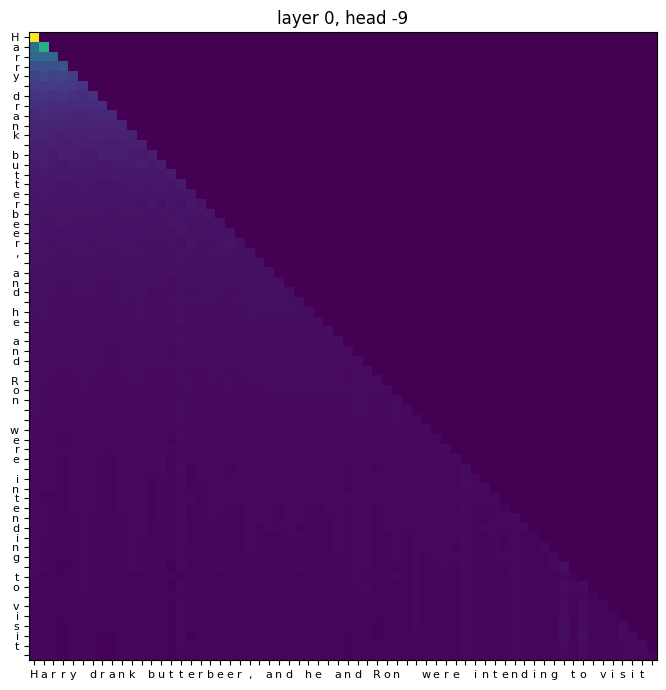

In [14]:
attention(0, -9)

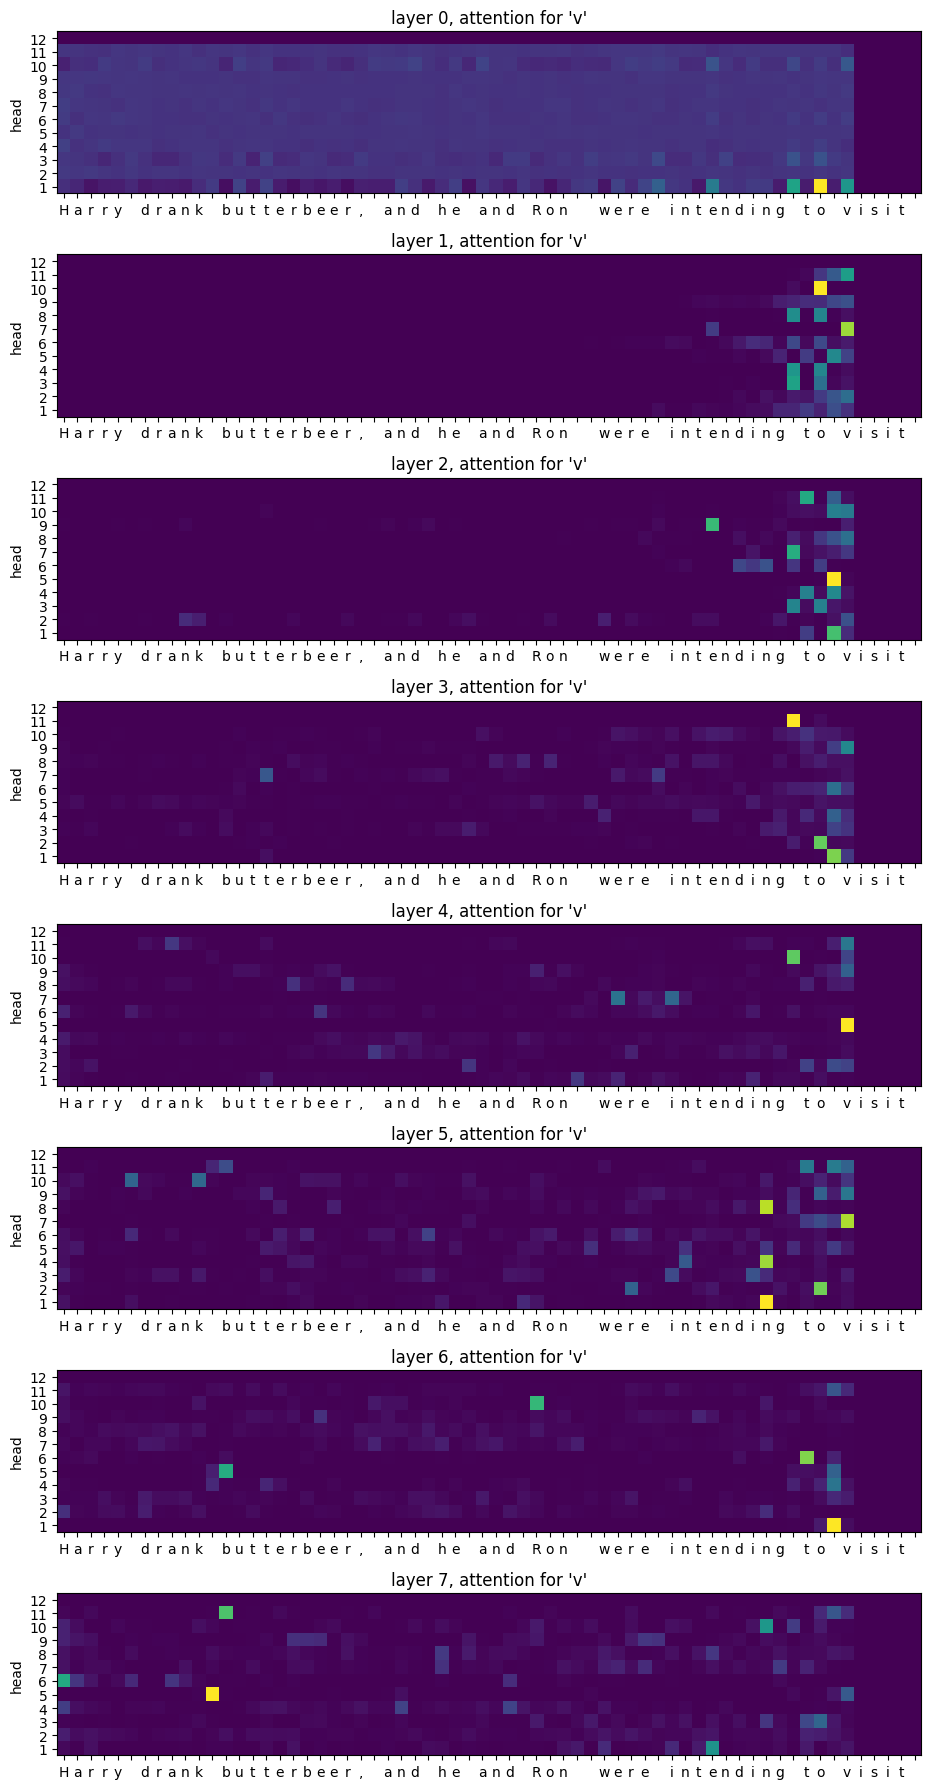

In [15]:
token_attention(-6)